# 5 Markov random fields

## Ex 2: MRF modelling for image segmentation

#### Segmentation modelling

The code provided in connection with the section 5.2 (MRF modelling for image segmentation) of the lecture notes.

In [1]:
import skimage.io
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt


You should write the code which computes segmentation energies (U1 and U2) as described in the lecture notes. The skeleton of the function is provided below. 

In [2]:
def segmentation_energy(S, I, mu, beta):
    
    # likelihood energy
    V1 = ((mu[S]-I)**2).sum()
    
    # prior energy
    V2x = S[1:,:]!=S[:-1,:]
    V2y = S[:,1:]!=S[:,:-1]
    V2 = beta * (V2x.sum() + V2y.sum())
    
    return(V1,V2)

A helping function for plotting the histograms of the data and the segmentation.

In [3]:
def segmentation_histogram(ax, D, S, edges=None):
    '''
    Plot histogram for grayscale data and each segmentation label.
    '''
    if edges is None:
        edges = np.linspace(D.min(), D.max(), 100)
    ax.hist(D.ravel(), bins=edges, color = 'k')
    centers = 0.5 * (edges[:-1] + edges[1:])
    for k in range(S.max() + 1):
        ax.plot(centers, np.histogram(D[S==k].ravel(), edges)[0])

Get hold of the data (noisy image) and ground truth segmentation.

In [16]:
path = 'data/'
D = skimage.io.imread(path + 'noisy_circles.png').astype(float)

# Get Ground-truth segmentation from noise-free image and get mu (mean of each class).
GT = skimage.io.imread(path + 'noise_free_circles.png')
(mu, S_gt) = np.unique(GT, return_inverse=True)
print(mu)
S_gt = S_gt.reshape(D.shape)

segmentations = [S_gt]  # list where I'll place different segmentations
#print(S_gt)

[ 70 130 190]


Find some configurations (segmentations) using conventional segmentation methods.


In [18]:
# Simple thresholding
S_t = np.zeros(D.shape, dtype=int) + (D > 100) + (D > 160) # thresholded
segmentations += [S_t]

# Gaussian filtering followed by thresholding
D_s = scipy.ndimage.gaussian_filter(D, sigma=1, truncate=3, mode='nearest')
S_g = np.zeros(D.shape, dtype=int) + (D_s > 100) + (D_s > 160) 
segmentations += [S_g]

# Median filtering followed by thresholding
D_m = scipy.ndimage.median_filter(D, size=(5, 5), mode='reflect')
S_t = np.zeros(D.shape, dtype=int) + (D_m > 100) + (D_m > 160) # thresholded
segmentations += [S_t]

Visualize the segmentations, associated histograms and error images. Once you implement the `segmentation_energy` you can look at whether there is a link between segmentation energies and the quality of the segmentation.



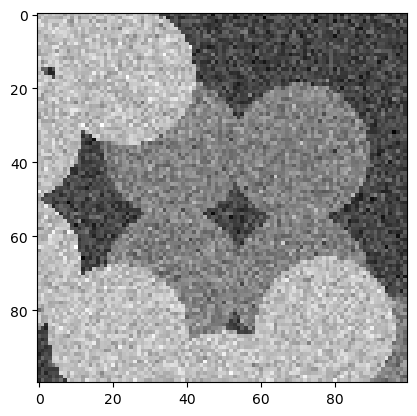

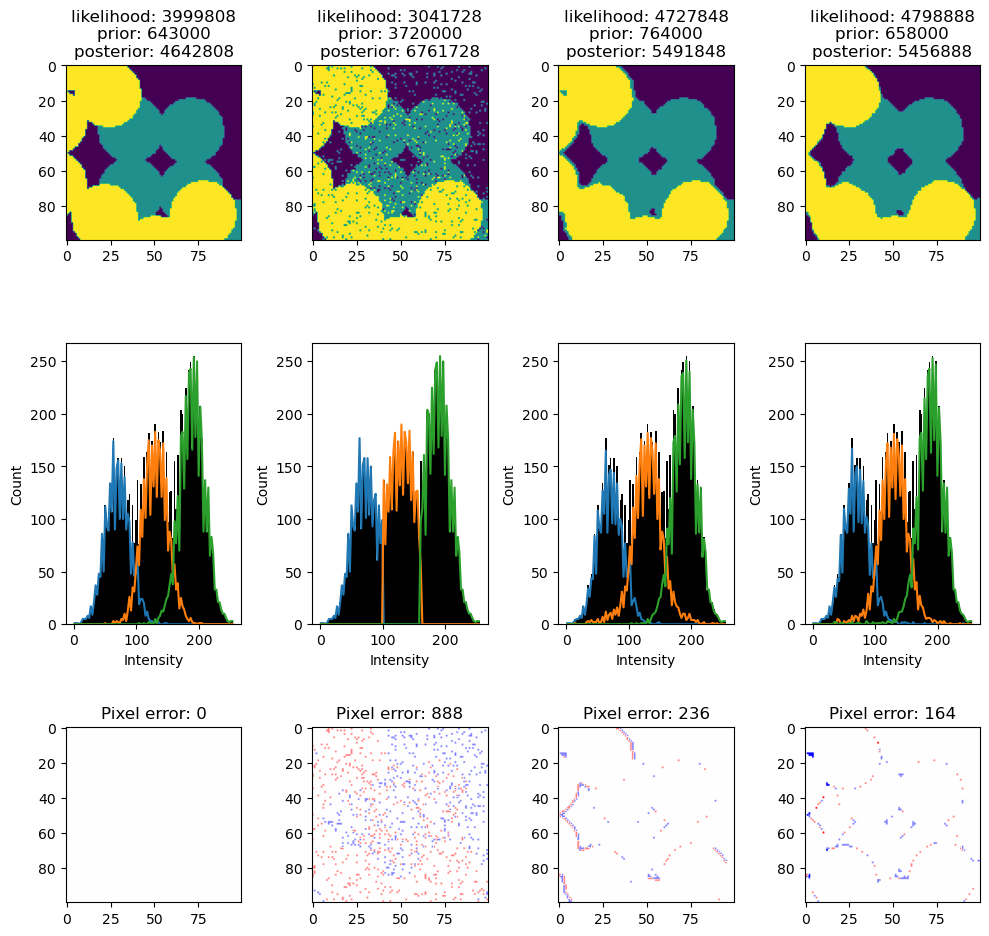

In [20]:
#%% visualization
fig, ax = plt.subplots()
ax.imshow(D, vmin=0, vmax=255, cmap=plt.cm.gray)
plt.show()


fig, ax = plt.subplots(3, len(segmentations), figsize=(10, 10))
beta = 1000

for i, s in enumerate(segmentations):
    ax[0][i].imshow(s)

    U1, U2 = segmentation_energy(s, D, mu, beta)
    ax[0][i].set_title(f'likelihood: {int(U1)}\nprior: {U2}\nposterior: {int(U1)+U2}')
    
    segmentation_histogram(ax[1][i], D, s)
    ax[1][i].set_xlabel('Intensity')
    ax[1][i].set_ylabel('Count')
    
    err = S_gt - s
    ax[2][i].imshow(err, vmin=-2, vmax=2, cmap=plt.cm.bwr)
    ax[2][i].set_title(f'Pixel error: {(err != 0).sum()}')

fig.tight_layout()
plt.show()   

Increase beta implies penalizing more the segmentation where lots of neightbor are different.
the best segmentation is supposed to be the one that minimize the ernegy

## Ex 3: Graph cuts for optimizing MRF (Notebook provided)

#### Example of using max-flow/min-cut algorithm for gender labeling problem

The code provided in connection with the section 5.3 (Graph cuts for optimizing MRF) of the lecture notes.

For solving max-flow/mic-cut we use `maxflow` package, see [https://pmneila.github.io/PyMaxflow/](https://pmneila.github.io/PyMaxflow/).

The example below is set-up exactly as in the lecture notes. You are adwised to experiment by changing the set up. In particular, try increasing the number of data points, for example as use the following for data term.
```
d = np.random.randint(low=145, high=201, size=50, dtype=int)
d += (5*np.sin(np.linspace(0, 4*np.pi, len(d)))).astype(int)

```

Also experiment with changing the value of `beta`. Setting `beta=0` corresponds to max-likelihood solution. Choosing larger `beta` should yield incresingly smooth solution.

In [21]:
import maxflow
import numpy as np
import matplotlib.pyplot as plt

#### Setting up the problem

[1296   64  225  289  784    4  196    0  484  361  121    9  324  256
  121  400  196  289  289  100    9  100    9  400    4    9  625  576
  961  441  484   64  529  625  484   81  256  324  196  676  529  256
  484    9    9   36 1521  529   16  100]


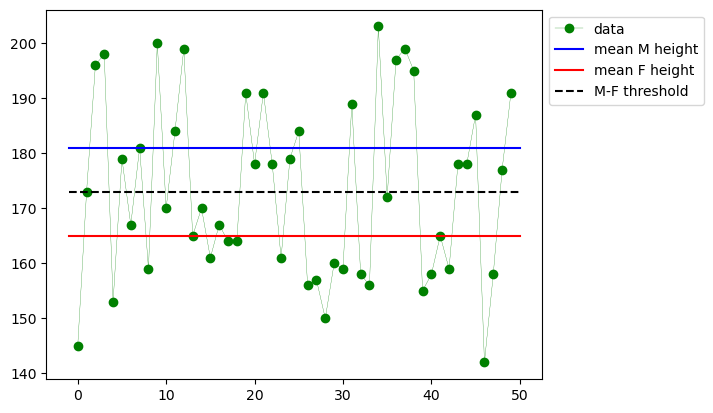

In [22]:
#d = np.array([179, 174, 182, 162, 175, 165]) # heights (data term)
d = np.random.randint(low=145, high=201, size=50, dtype=int)
d += (5*np.sin(np.linspace(0, 4*np.pi, len(d)))).astype(int) 

mu = [181, 165] # means of two classes, used for computation of likelihood
w_s = (d - mu[0])**2 # source weight
w_t = (d - mu[1])**2 # sink weights
print(w_s)

fig, ax = plt.subplots()
ax.plot(d, '-og', lw=0.2, label='data')
ax.plot([-1, len(d)], [mu[0]]*2, 'b', label='mean M height')
ax.plot([-1, len(d)], [mu[1]]*2, 'r', label='mean F height')
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k', label='M-F threshold')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Solving the assignment problem using graph-cut

Maximum flow: 7066
Results: ['F', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'F', 'M', 'M']


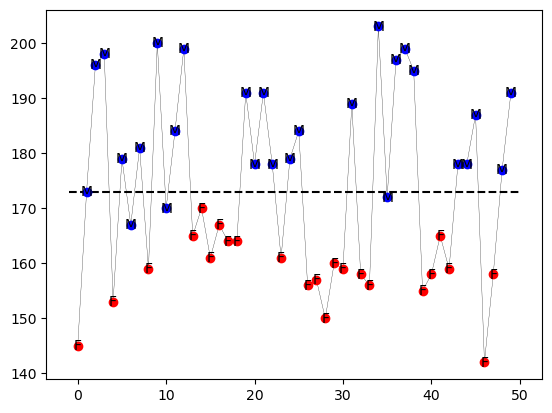

In [23]:
beta = 100  # try changing between 0 and 1000

# Create a graph with integer capacities.
g = maxflow.Graph[int]()

# Add (non-terminal) nodes and retrieve an index for each node.
nodes = g.add_nodes(len(d))

# Create edges between nodes.
for i in range(len(d)-1):
    g.add_edge(nodes[i], nodes[i+1], beta, beta)

# Set the capacities of the terminal edges.
for i in range(len(d)):
    g.add_tedge(nodes[i], (d[i]-mu[1])**2, (d[i]-mu[0])**2)

# Run the max flow algorithm.
flow = g.maxflow()
print(f'Maximum flow: {flow}')

# Get the result as integer labels.
labeling = [g.get_segment(n) for n in nodes]

# Get the results as either 'M or 'F.
labeling_str = ['MF'[l] for l in labeling]
print(f'Results: {labeling_str}')

# Visualize
fig, ax = plt.subplots()
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k')
ax.plot(d, '-k', lw=0.2)
for i, di in enumerate(d):
    ax.plot(i, di, 'o'+'br'[labeling[i]])
    ax.text(i, di, labeling_str[i], ha='center', va='center')
plt.show()

## Ex 4: Binary segmentation using MRF

### DTU Binary

In [24]:
import skimage.io
import matplotlib.pyplot as plt
import maxflow
import numpy as np

In [25]:
def segmentation_histogram(ax, I, S, edges=None):
    '''
    Histogram for data and each segmentation label.
    '''
    if edges is None:
        edges = np.linspace(I.min(), I.max(), 100)
    ax.hist(I.ravel(), bins=edges, color = 'k')
    centers = 0.5*(edges[:-1] + edges[1:]);
    for k in range(S.max()+1):
        ax.plot(centers, np.histogram(I[S==k].ravel(), edges)[0])

In [32]:
# noisy image
path = 'data/'
I = skimage.io.imread(path + 'DTU_noisy.png').astype(float)/255

# MRF parameters
beta  = 0.1
mu = [90/255, 170/255]

# Setting up graph with internal and external edges
g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes(I.shape)
g.add_grid_edges(nodeids, beta)
g.add_grid_tedges(nodeids, (I-mu[1])**2, (I-mu[0])**2)

#  Graph cut
g.maxflow()
S = g.get_grid_segments(nodeids)
print(S)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


Text(0.5, 1.0, 'Segmentation histogram')

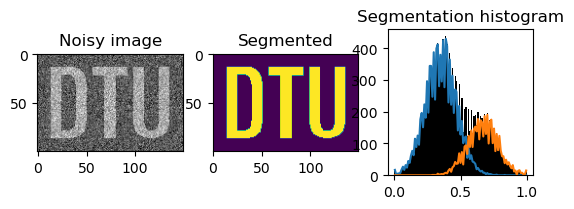

In [28]:
# Visualization
fig, ax = plt.subplots(1, 3)
ax[0].imshow(I, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[0].set_title('Noisy image')
ax[1].imshow(S)
ax[1].set_title('Segmented')
segmentation_histogram(ax[2], I, S, edges=None)
ax[2].set_aspect(1./ax[2].get_data_ratio())
ax[2].set_title('Segmentation histogram')

### Bone Binary

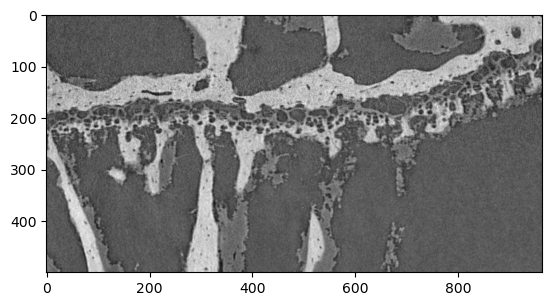

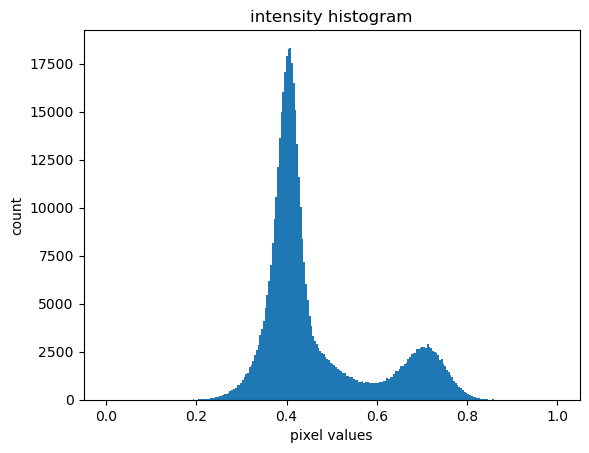

In [29]:
#%% Inspect the image and the histogram
path = 'data/'
I = skimage.io.imread(path + 'V12_10X_x502.png').astype(float)/(2**16-1)

fig, ax = plt.subplots()
ax.imshow(I, cmap=plt.cm.gray)

edges = np.linspace(0, 1, 257)
fig, ax = plt.subplots()
ax.hist(I.ravel(), edges)
ax.set_xlabel('pixel values')
ax.set_ylabel('count')
ax.set_title('intensity histogram')

Text(0.5, 1.0, 'max likelihood')

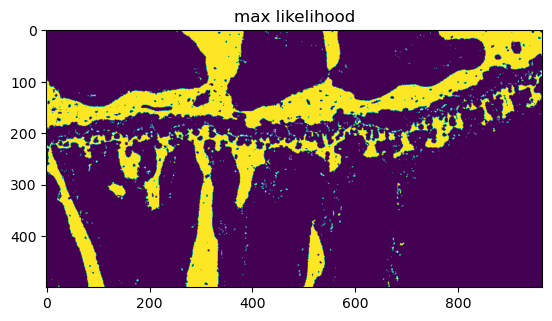

In [30]:
#%% Define likelihood
mu = np.array([0.40, 0.71])
U = np.stack([(I-mu[i])**2 for i in range(len(mu))],axis=2)
S0 = np.argmin(U,axis=2)

fig, ax = plt.subplots()
ax.imshow(S0)
ax.set_title('max likelihood')

Text(0.5, 1.0, 'segmentation histogram')

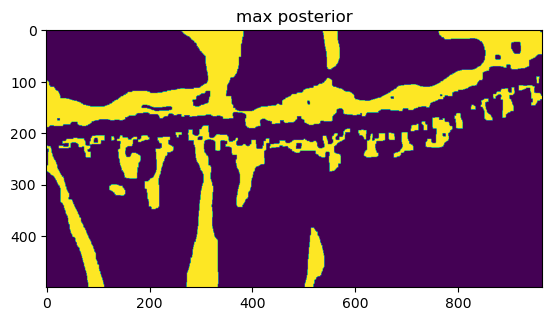

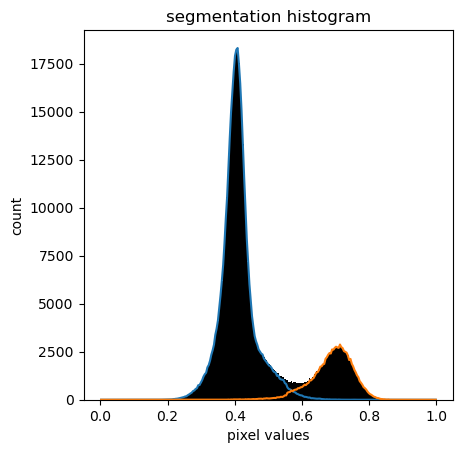

In [31]:
#%% Define prior, construct graph, solve
beta  = 0.1
g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes(I.shape)
g.add_grid_edges(nodeids, beta)
g.add_grid_tedges(nodeids, U[:,:,1], U[:,:,0])

#  solving
g.maxflow()
S = g.get_grid_segments(nodeids)

fig, ax = plt.subplots()
ax.imshow(S)
ax.set_title('max posterior')

fig, ax = plt.subplots()
segmentation_histogram(ax, I, S, edges=edges)
ax.set_aspect(1./ax.get_data_ratio())
ax.set_xlabel('pixel values')
ax.set_ylabel('count')
ax.set_title('segmentation histogram')

## Ex 5: Multilabel segmentation usign MRF (optional)

### Circle 3 labels

In [35]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import maxflow.fastmin

[ 70 130 190]


Text(0.5, 1.0, 'max posterior')

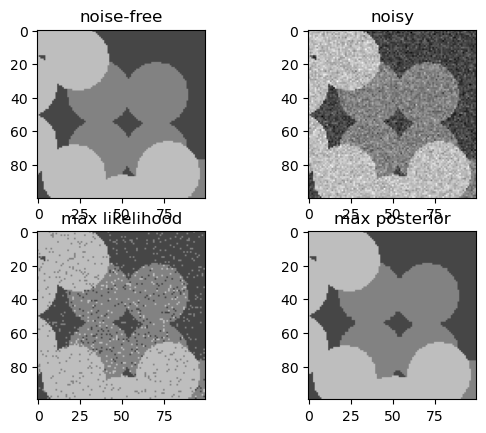

In [43]:
#%%
path = 'data/'
GT = skimage.io.imread(path + 'noise_free_circles.png') # ground truth
I = skimage.io.imread(path + 'noisy_circles.png')
mu = np.unique(GT) # instead of estimating
print(mu)

# converting all to float
I = I.astype(np.float64)/255
GT = GT.astype(np.float64)/255
mu = mu.astype(np.float64)/255

beta = 0.05
D = np.stack([(I-mu[i])**2 for i in range(3)], axis=2)
V = beta - beta*np.eye(len(mu), dtype = D.dtype)

#%%
S0 = np.argmin(D, axis=2)
S = S0.copy()
maxflow.fastmin.aexpansion_grid(D, V, labels = S)

# covert segmented 1, 2, 3 to segmented float64
D0 = mu[S0] 
D = mu[S] # denoised image using intensities from mu

fig, ax = plt.subplots(2, 2)
ax = ax.ravel()
ax[0].imshow(GT, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[0].set_title('noise-free')
ax[1].imshow(I, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[1].set_title('noisy')
ax[2].imshow(D0, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[2].set_title('max likelihood')
ax[3].imshow(D, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[3].set_title('max posterior')

### Bone 3 labels

Text(0.5, 1.0, 'intensity histogram')

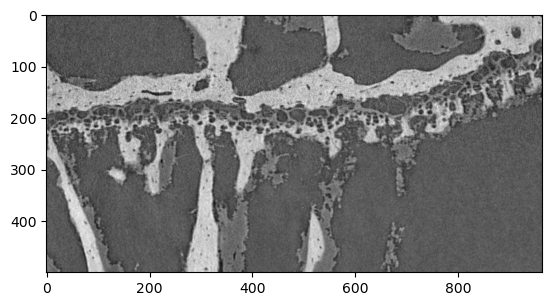

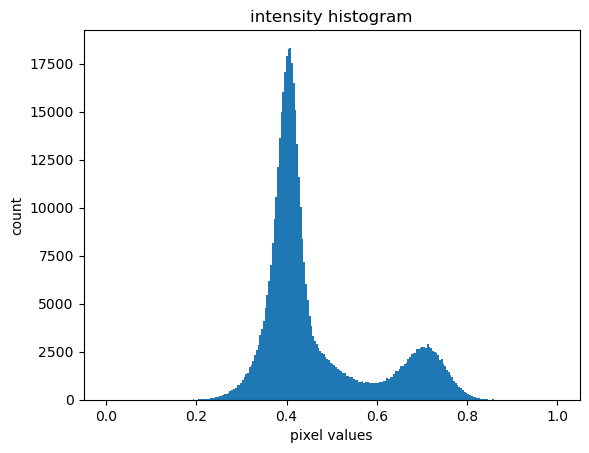

In [44]:
#%% Inspect the image and the histogram
I = skimage.io.imread(path + 'V12_10X_x502.png').astype(float)/(2**16-1)
fig, ax = plt.subplots()
ax.imshow(I, cmap=plt.cm.gray)

edges = np.linspace(0, 1, 257)
fig, ax = plt.subplots()
ax.hist(I.ravel(), edges)
ax.set_xlabel('pixel values')
ax.set_ylabel('count')
ax.set_title('intensity histogram')

Text(0.5, 1.0, 'max likelihood')

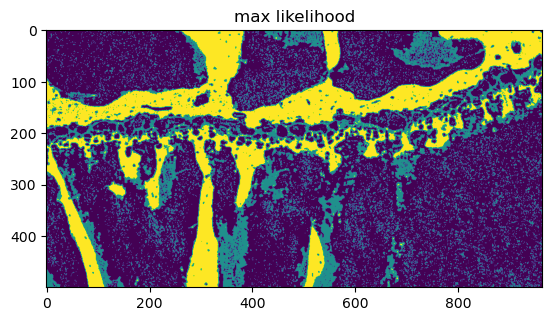

In [45]:
#%% Define likelihood
mu = np.array([0.40, 0.46, 0.71])
U = np.stack([(I-mu[i])**2 for i in range(len(mu))],axis=2)
S0 = np.argmin(U,axis=2)

fig, ax = plt.subplots()
ax.imshow(S0)
ax.set_title('max likelihood')

Text(0.5, 1.0, 'segmentation histogram')

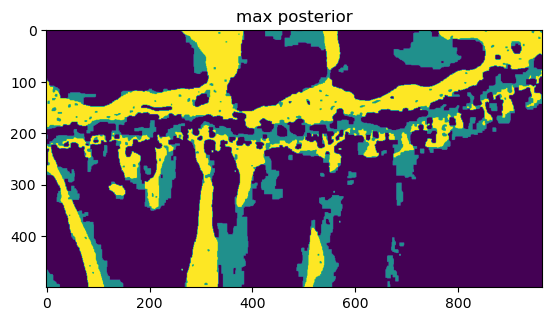

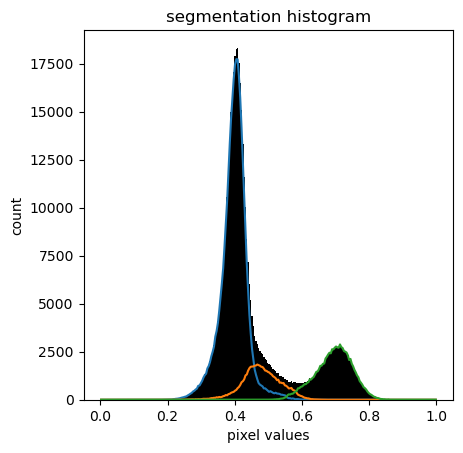

In [46]:
#%% Define prior and solve
beta  = 0.02
B = beta - beta*np.eye(len(mu))
#  solving
S = S0.copy()
maxflow.fastmin.aexpansion_grid(U, B, labels = S) # modify S


fig, ax = plt.subplots()
ax.imshow(S)
ax.set_title('max posterior')

fig, ax = plt.subplots()
segmentation_histogram(ax, I, S, edges=edges)
ax.set_aspect(1./ax.get_data_ratio())
ax.set_xlabel('pixel values')
ax.set_ylabel('count')
ax.set_title('segmentation histogram')

In [47]:
help(maxflow.fastmin.aexpansion_grid)

Help on function aexpansion_grid in module maxflow.fastmin:

aexpansion_grid(unary, binary, max_cycles=None, labels=None)
    Minimize an energy function iterating the alpha-expansion until convergence
    or until a maximum number of cycles, given by ``max_cycles``, is reached.
    
    ``unary`` must be an N+1-dimensional array with shape (S1, ..., SN, L),
    where L is the number of labels. *unary[p1, ... ,pn ,lbl]* is the unary cost
    of assigning the label *lbl* to the variable *(p1, ..., pn)*.
    
    ``binary`` is a two-dimensional array. *binary[lbl1, lbl2]* is the binary
    cost of assigning the labels *lbl1* and *lbl2* to a pair of neighbor
    variables. Note that the distance defined by ``binary`` must be a metric or
    else the aexpansion might converge to invalid results.
    
    The optional N-dimensional array ``labels`` gives the initial labeling of
    the algorithm. If omitted, the function will initialize the labels using the
    minimum unary costs given by 